# TCNN for predicting streamflow error in PCR model

A Temporla Convolutional Neural Network is built using tensorflow and tcn.

In [ ]:
#install libraries
!pip install keras-tcn
!pip install hydroeval
!pip install -q -U keras-tuner

Trial 8 Complete [00h 00m 08s]
val_mean_squared_error: 1145651.75

Best val_mean_squared_error So Far: 938051.375
Total elapsed time: 00h 01m 02s
INFO:tensorflow:Oracle triggered exit
Units: 200
Receptive field size = 61
Epoch 1/150
145/145 [==============================] - 5s 19ms/step - loss: 898533.1250 - mean_squared_error: 898369.1875 - val_loss: 1073637.0000 - val_mean_squared_error: 1059701.6250
Epoch 2/150
145/145 [==============================] - 2s 15ms/step - loss: 786561.2500 - mean_squared_error: 786440.8125 - val_loss: 967878.9375 - val_mean_squared_error: 953609.3125
Epoch 3/150
145/145 [==============================] - 2s 15ms/step - loss: 676521.4375 - mean_squared_error: 676403.3125 - val_loss: 864206.3750 - val_mean_squared_error: 849921.6250
Epoch 4/150
145/145 [==============================] - 2s 15ms/step - loss: 560046.2500 - mean_squared_error: 560119.1875 - val_loss: 757174.5000 - val_mean_squared_error: 743378.2500
Epoch 5/150
145/145 [====================

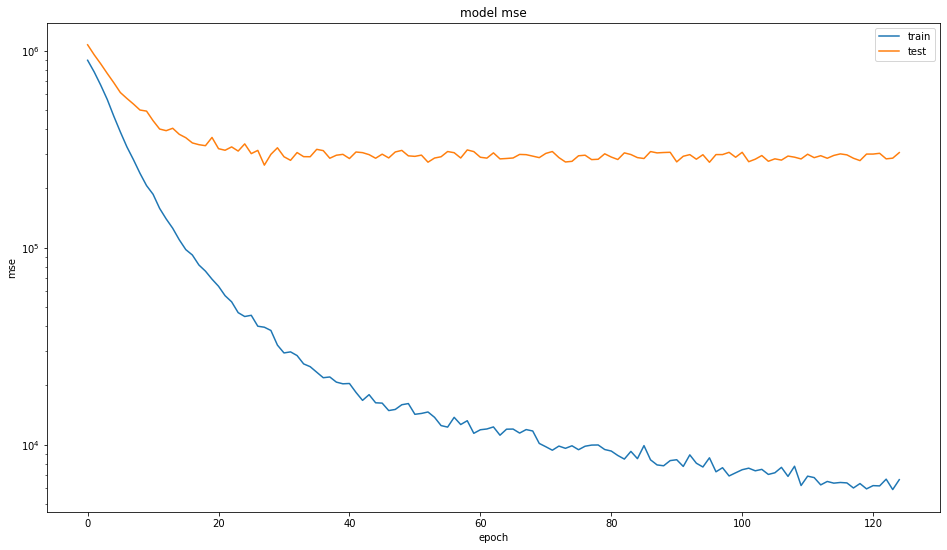

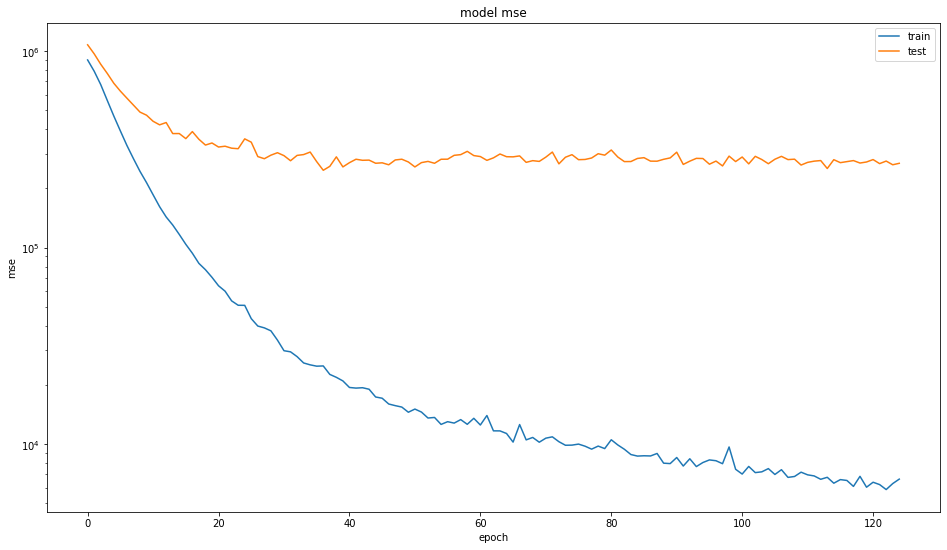

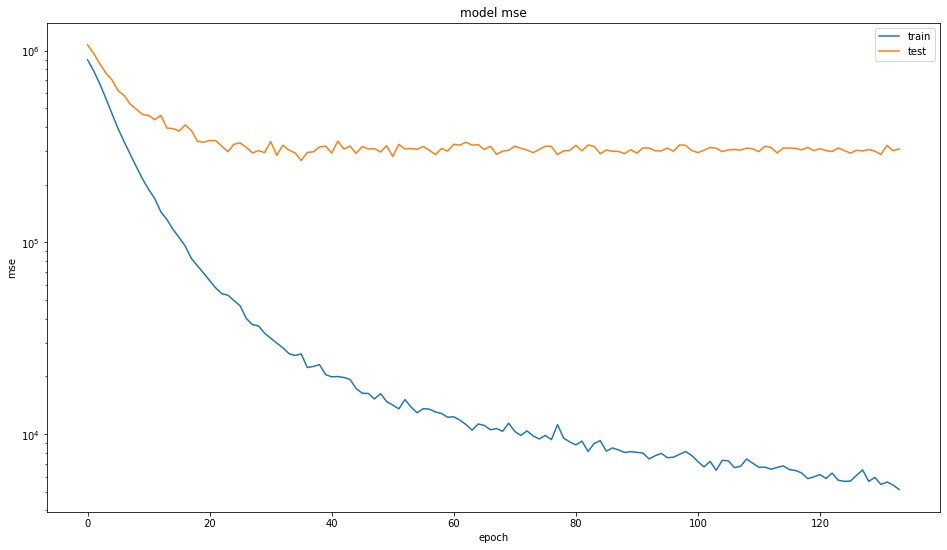

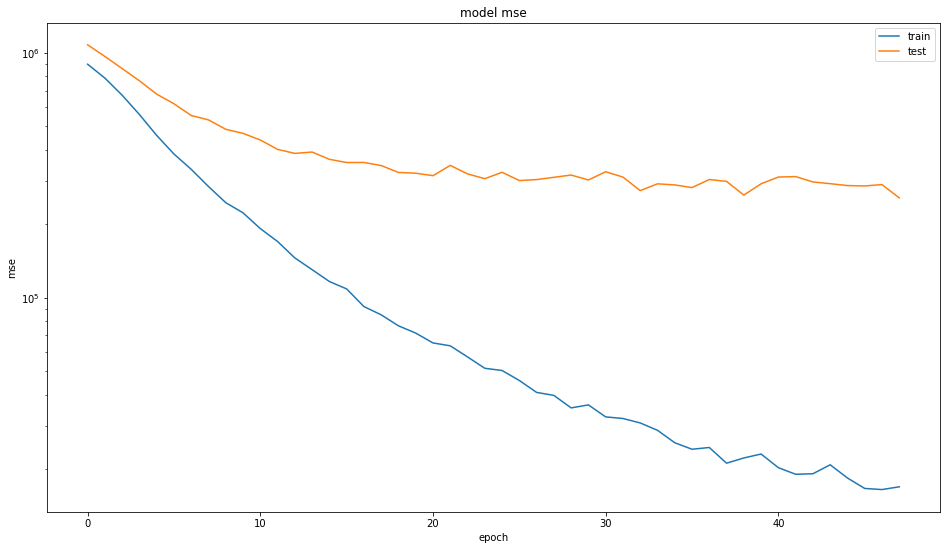

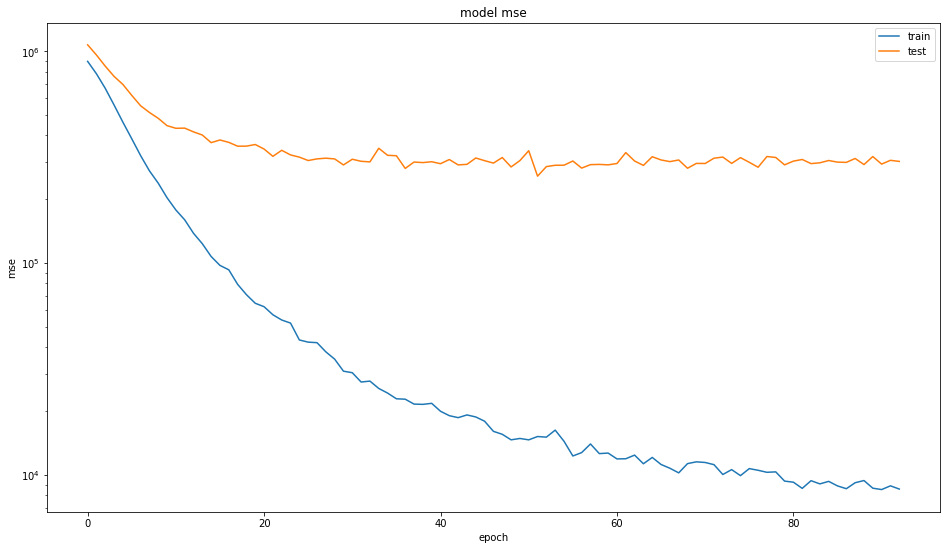

In [3]:
#define the parameters
RUNS = 5
TIME_STEPS = 60
DIFF_TEST = False
LOCATION = 'lobith'

#importing relevant libraries
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import hydroeval as he
import keras_tuner as kt
from datetime import datetime
import matplotlib.pyplot as plt
from tcn import TCN

#set input and output folders
in_folder = f'/content/drive/MyDrive/ADS/Final Thesis Project/temp/formatted_data/{LOCATION}/'
out_folder = f'/content/drive/MyDrive/ADS/Final Thesis Project/temp/predictions/{LOCATION}/'

#initiate the summary string by writing the current time and date
starting_time = datetime.now()
tcn_summary = starting_time.strftime("%d/%m/%Y %H:%M:%S") + '\n'

#define the model
def baseline_model(hp):
  units_0 = hp.Int('units_0', 25, 200, step=25)
  #set up the tcn layers
  tcn_layer_0 = TCN(input_shape=(TIME_STEPS, input_vars),
                  nb_filters= units_0,
                  kernel_size= 3,
                  dilations=(1, 2, 4, 8),
                  padding='causal',
                  dropout_rate=0.05,
                  use_layer_norm=True,
                  return_sequences = False)
  
  print('Receptive field size =', tcn_layer_0.receptive_field)

  model = keras.Sequential([tcn_layer_0,
                            keras.layers.Dense(1, activation='linear')])
  model.compile(optimizer='adam', 
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.losses.MeanSquaredError()])

  return model

#loop for all runs/test sets
for i in range(1,RUNS+1):
  print('RUN NUMBER:',i)

  #read the data according to the mode
  if DIFF_TEST:
    path = in_folder + f'lag_{i}.npz'
  else:
    path = in_folder + f'lag_{5}.npz'

  with np.load(path) as f:
    X_train, X_test, y_train, y_test, obs = list(f.values())

  #set up some more parameters
  input_vars = X_train.shape[1]//TIME_STEPS

  #set up the lagged variables according to the model needs
  X_train_win = np.zeros((X_train.shape[0], TIME_STEPS, input_vars))
  X_test_win = np.zeros((X_test.shape[0], TIME_STEPS, input_vars))

  for o in range(X_train.shape[0]):
    for v in range(input_vars):
        X_train_win[o][:,v] = np.flip(X_train[o][v*TIME_STEPS:(v+1)*TIME_STEPS])

  for o in range(X_test.shape[0]):
    for v in range(input_vars):
        X_test_win[o][:,v] = np.flip(X_test[o][v*TIME_STEPS:(v+1)*TIME_STEPS])

  #instantiate the Hyperband tuner
  tuner = kt.Hyperband(baseline_model,
                       overwrite= True,
                       objective='val_mean_squared_error',
                       max_epochs = 50,
                       directory='my_dir',
                       project_name='tcn_' + 'run_'*(not DIFF_TEST) + 
                       'test_'*DIFF_TEST + str(i))
  
  #create a callback to stop training early after reaching a certain value for the validation loss.
  stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=10)

  #run the tuner
  tuner.search(X_train_win, y_train, epochs=150, validation_split=0.2, callbacks=[stop_early])

  #get the optimal hyperparameters
  best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
  params = f"Units: {best_hps.get('units_0')}"
  print(params)

  # build the model with the optimal hyperparameters and find the optimal number of epochs
  model = tuner.hypermodel.build(best_hps)
  history = model.fit(X_train_win, y_train, epochs=150, validation_split=0.2)
  mse_per_epoch = history.history['val_mean_squared_error']
  best_epoch = mse_per_epoch.index(min(mse_per_epoch)) + 1
  print('Best epoch: %d' % (best_epoch,))

  #re-instantiate the hypermodel and train it with the optimal number of epochs from above.
  hypermodel = tuner.hypermodel.build(best_hps)
  history = hypermodel.fit(X_train_win, y_train, epochs=best_epoch, validation_split=0.2)

  #save a plot of the training history
  plt.figure(figsize = (16,9))
  plt.plot(history.history['loss'], label = 'train')
  plt.plot(history.history['val_loss'], label = 'test')
  plt.title('model mse')
  plt.ylabel('mse')
  plt.xlabel('epoch')
  plt.yscale('log')

  plt.legend()
  plt.savefig(out_folder + 'lag/tcn/history_' + 'run_'*(not DIFF_TEST) + 
              'test_'*DIFF_TEST + f'{i}.png')
    
  #compute the FCN  predictions and evaluate them
  y_pred =  model.predict(X_test_win)
  pred = obs - y_test + y_pred.flatten()

  nse = he.evaluator(he.nse, pred, obs)
  kge, r, alpha, beta = he.evaluator(he.kge, pred, obs)

  #write the results in the log string
  tcn_summary += (f'***\nModel: TCN\nParameters: {params}\n' +
                  'Test split: ' + str(i)*DIFF_TEST + '5'*(not DIFF_TEST) +
                  f'\nNSE: {nse[0]}\nKGE: {kge[0]}\n')

  #save the predictions in the drive
  np.save(out_folder + 'lag/tcn/tcn_' + 'run_'*(not DIFF_TEST) + 'test_'*DIFF_TEST + str(i), pred)

#print the time when the algorithm finished
ending_time = datetime.now()
duration = ending_time - starting_time
tcn_summary += '***\nEnd time: ' + ending_time.strftime("%H:%M:%S") + '\n'
tcn_summary += f'Duration: {duration}'
print(tcn_summary)

#save the results
with open(out_folder + 'lag/tcn/tcn_' + 'run'*(not DIFF_TEST) + 'test'*DIFF_TEST +'_summary.txt', 'w') as f:
    f.write(tcn_summary)